In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
import warnings 
warnings.filterwarnings('ignore')

In [48]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [49]:
data.dtypes[data.dtypes == 'object'].index

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges',
       'Churn'],
      dtype='object')

In [50]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype(str)

In [51]:
data['TotalCharges'] = data['TotalCharges'].apply(lambda x: pd.to_numeric(x, errors = 'coerce')).dropna()
data['TotalCharges'] = data['TotalCharges'].fillna(data.TotalCharges.mean())

## EDA

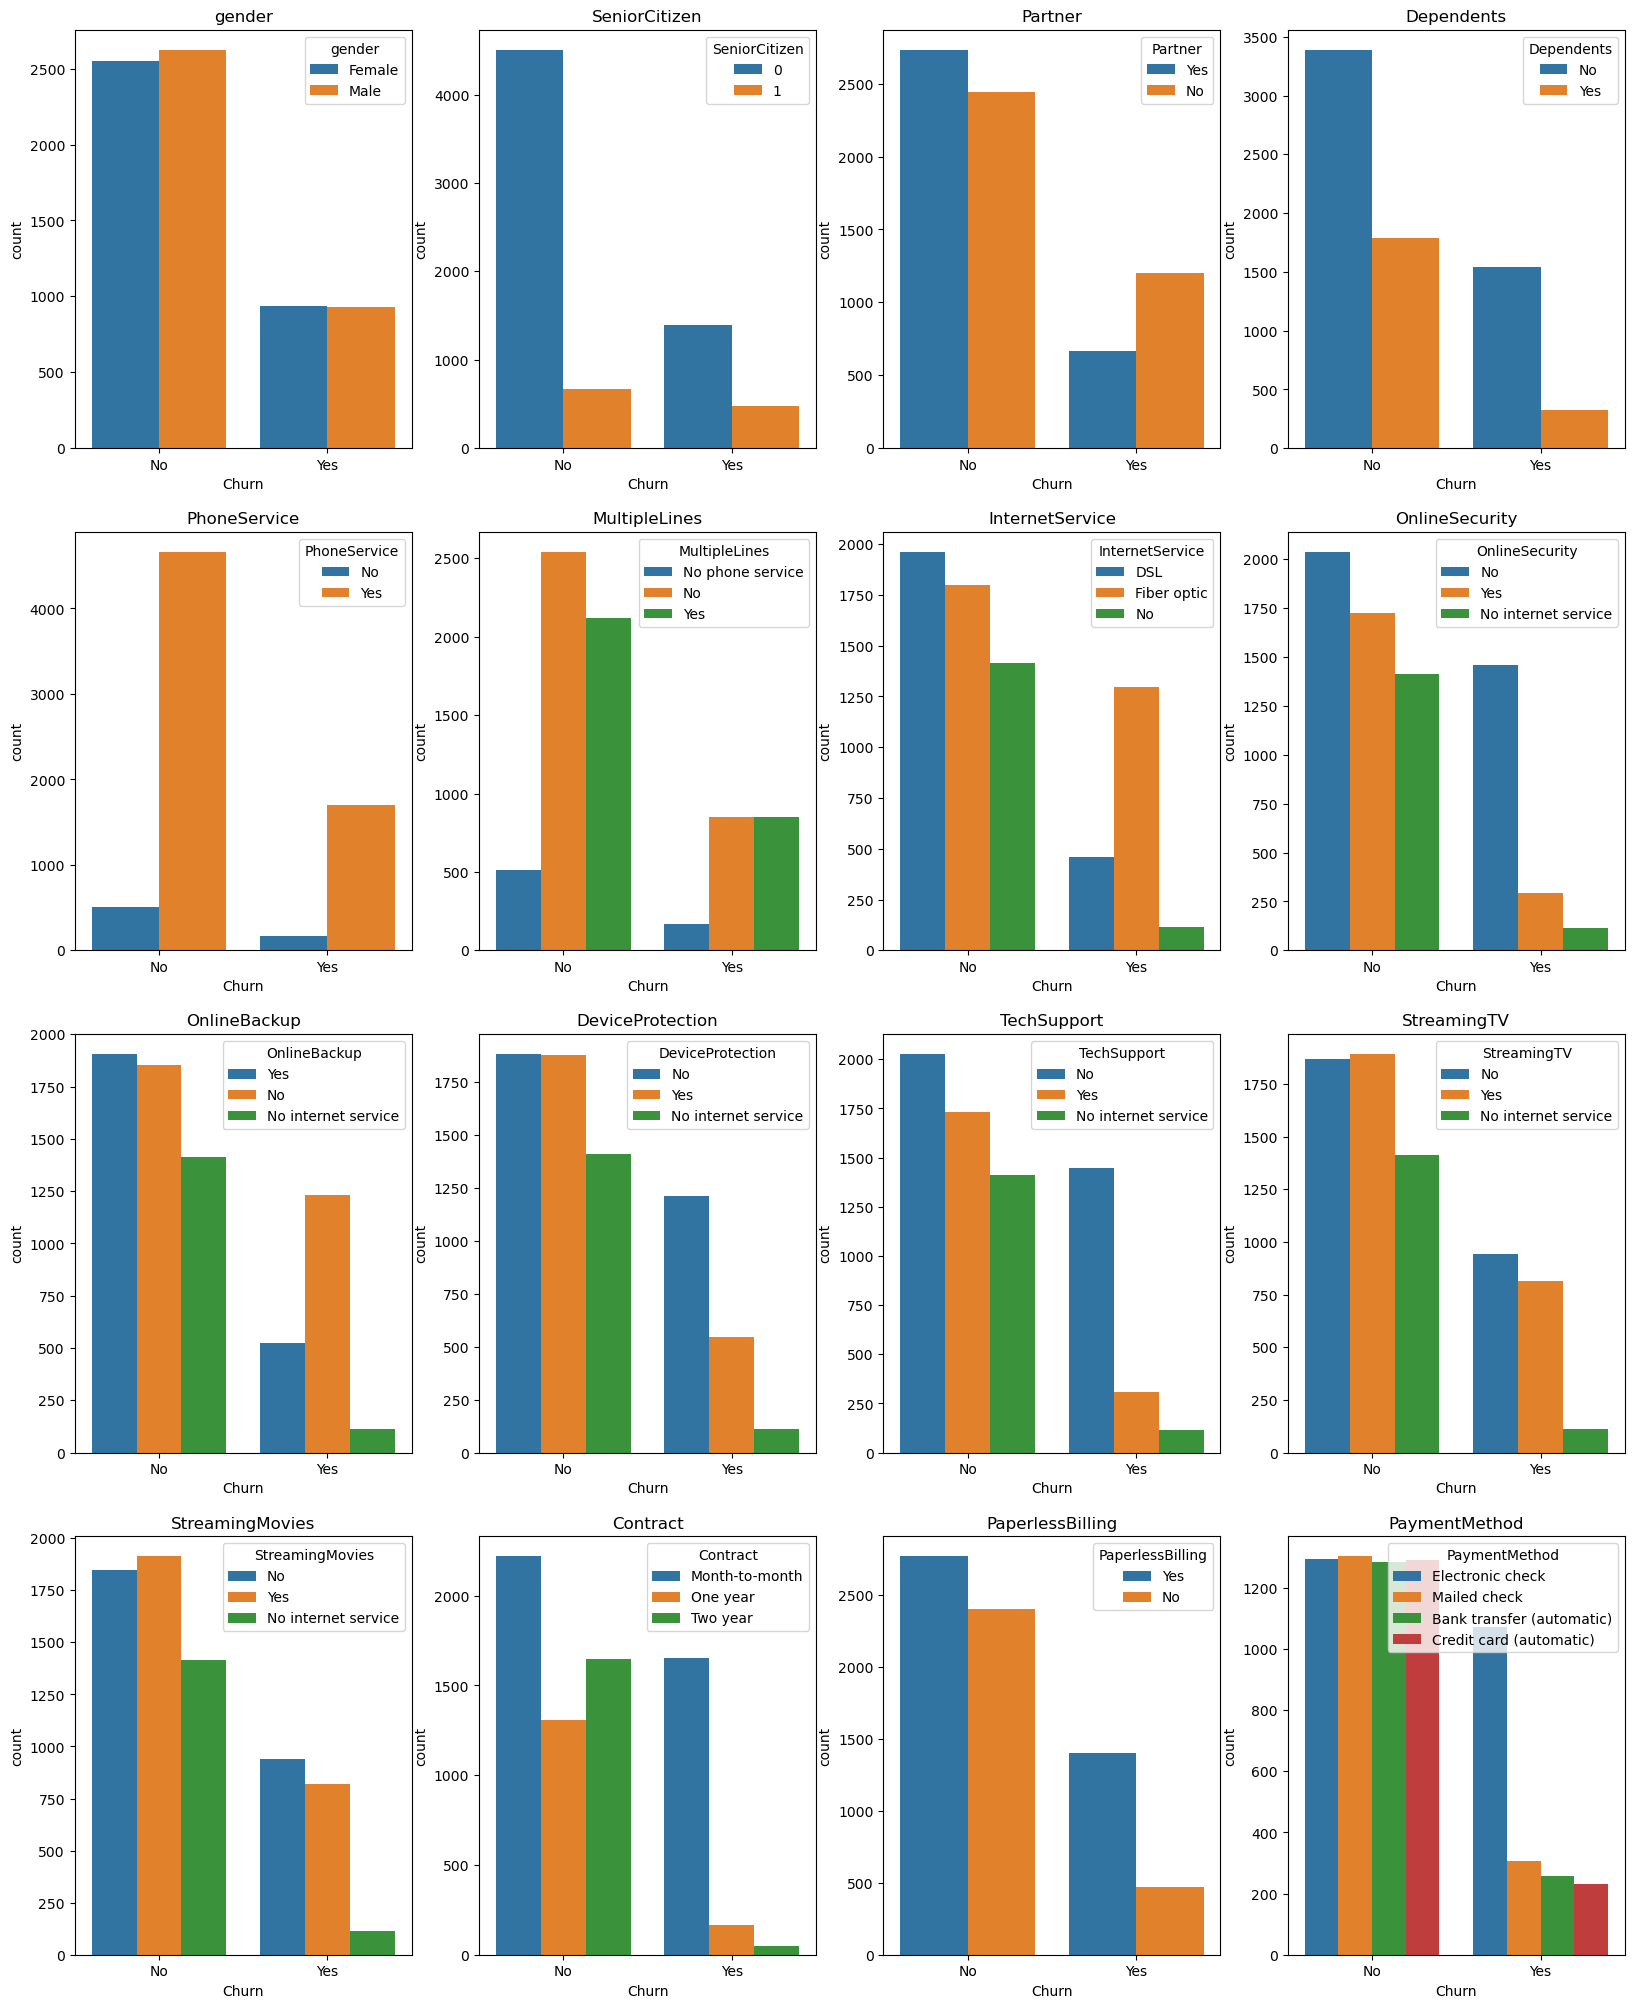

In [52]:
# Categorical
cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod']

plt.figure(figsize=(20,25))

for i, col in enumerate(cols):
    ax = plt.subplot(4, 4, i+1)
    sns.countplot(x = 'Churn', hue = str(col), data = data)
    ax.set_title(f"{col}")

Some takeaways:  
* The gender proportions are similar no matter whether the customers churned or not.
* A larger proportion of young citizens chose not to churn compared to the seniors.
* Customers with dependents are less likely to churn.
* Many more customers with month-to-month contract chose to move out compared to those with one-year or two-year contract.
* Customers who opted for credit card transfer or bank transfer and mailed check as payment method were less likely to churn.

[Text(0.5, 1.0, 'total charges')]

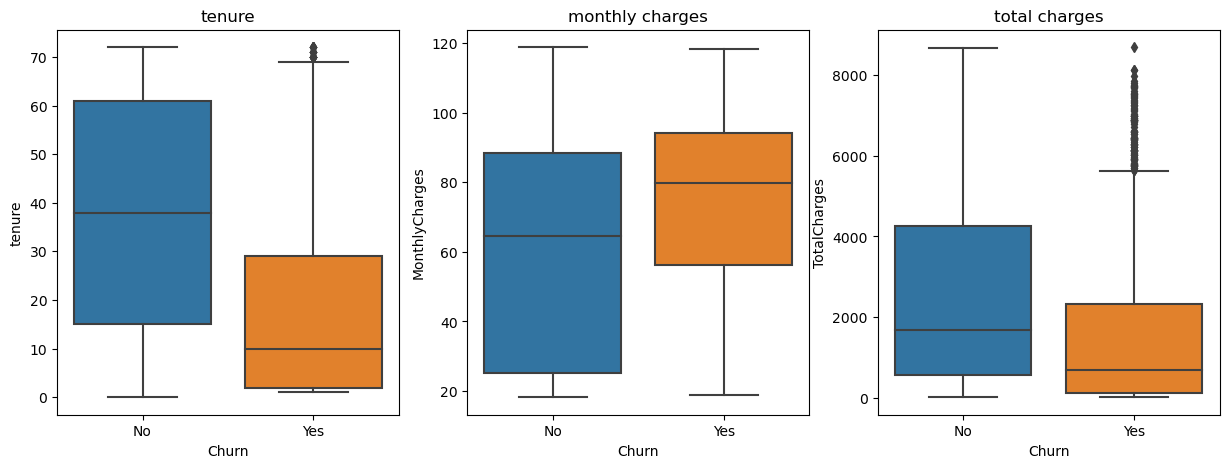

In [53]:
# Numerical
fig, axes = plt.subplots(1,3, figsize = (15,5))
sns.boxplot(x = 'Churn', y = 'tenure', data = data, ax=axes[0]).set(title = 'tenure')
sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data = data, ax=axes[1]).set(title = 'monthly charges')
sns.boxplot(x = 'Churn', y = 'TotalCharges', data = data, ax=axes[2]).set(title = 'total charges')

Some takeaways:  
* Fewer customers churned as the tenure increased.
* Customers were more likely to churn when the monthly charges were high.
* There was higer churn when the total charges were lower.

<AxesSubplot:xlabel='TotalCharges', ylabel='Density'>

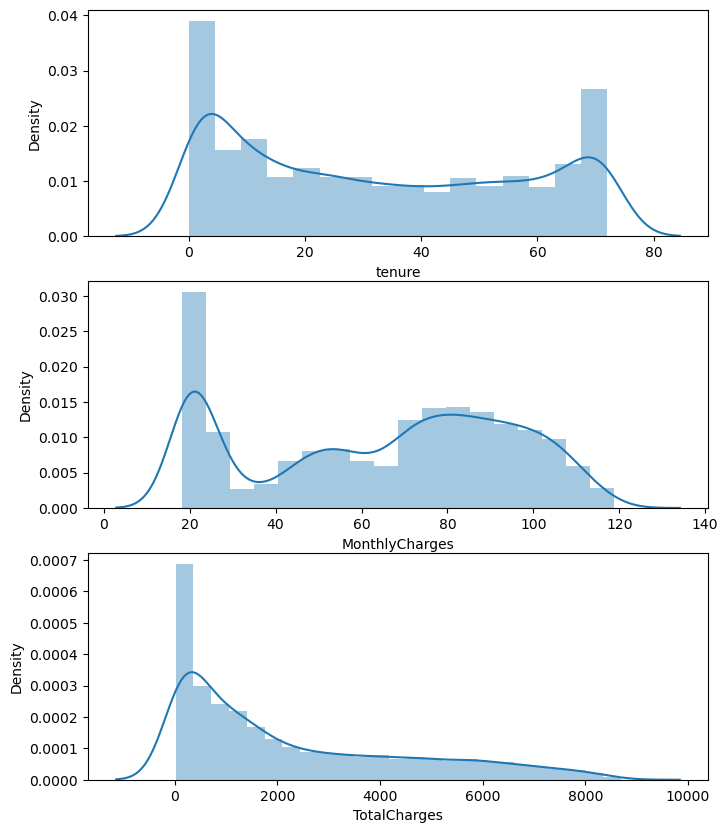

In [8]:
# numerical values need to be scaled, in this case, normalized
fig, axes = plt.subplots(3, 1, figsize = (8,10))
sns.distplot(data['tenure'], ax = axes[0])
sns.distplot(data['MonthlyCharges'], ax = axes[1])
sns.distplot(data['TotalCharges'], ax = axes[2])

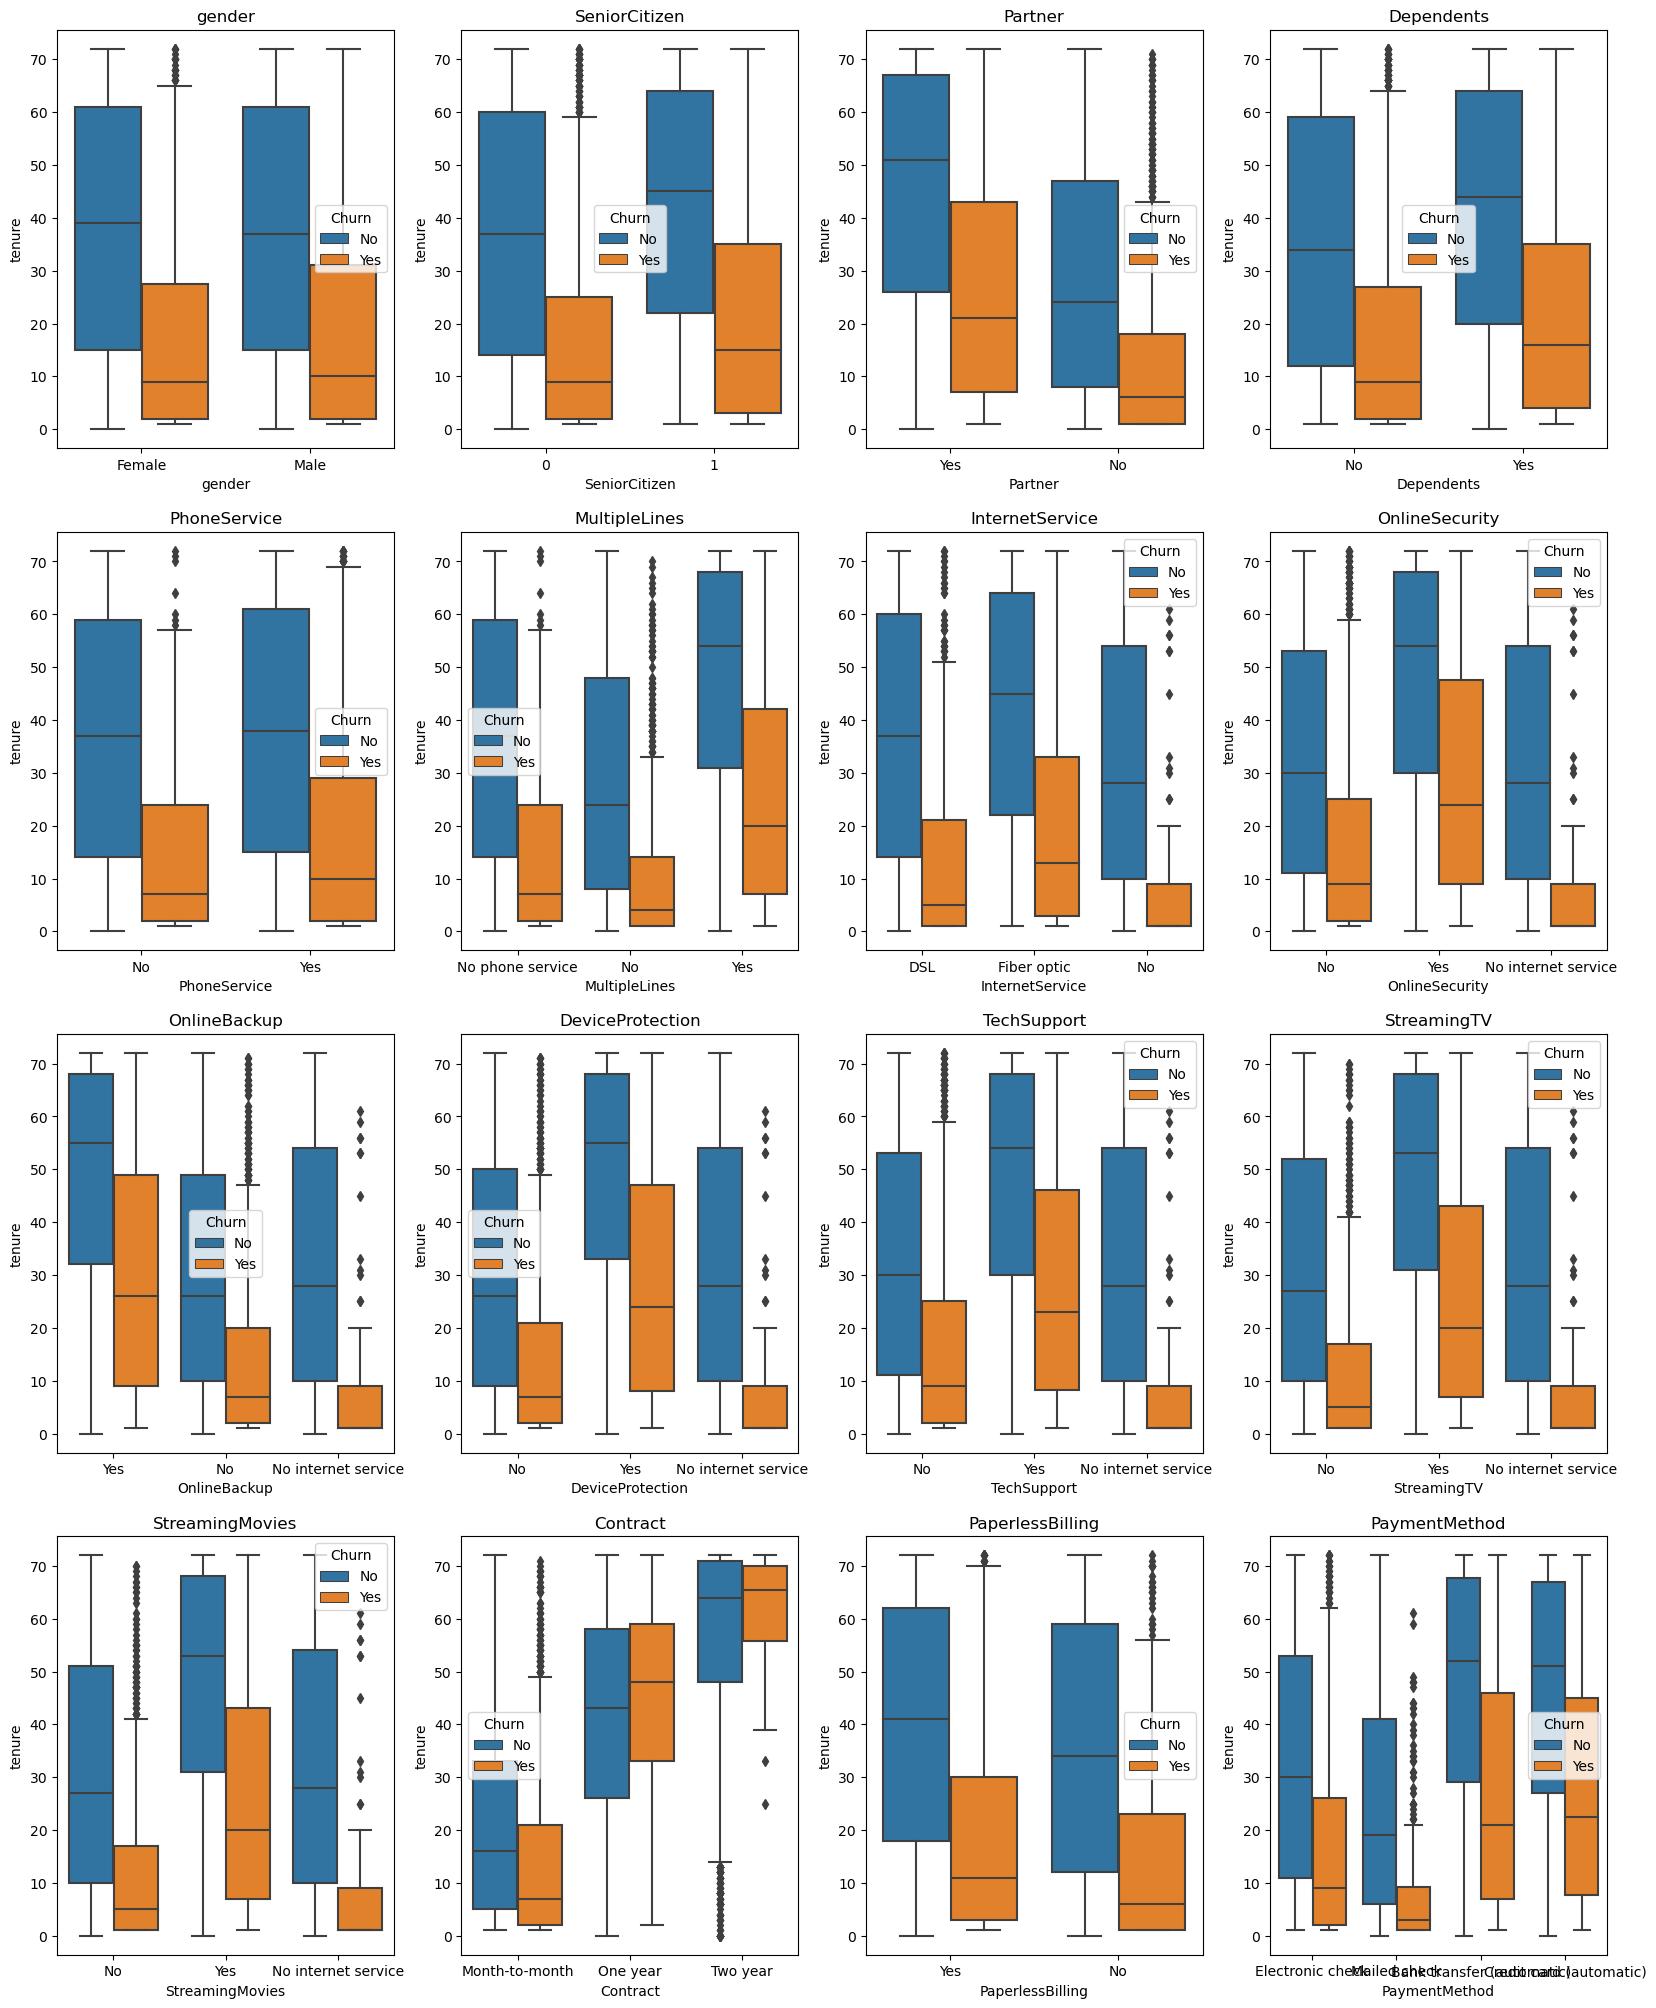

In [54]:
# Categorical vs. Numerical
plt.figure(figsize=(20,25))

for i, col in enumerate(cols):
    ax = plt.subplot(4, 4, i+1)
    sns.boxplot(x = col, y = 'tenure', data = data, hue = 'Churn')
    ax.set_title(f"{col}")

Some takeaways:  
* Customers without partners generally opted out for the service with smaller tenure values.
* Availability of phone service or not did not affect customers' decision to opt out with respect to tenure period. Customers were probably not heavy phone service users.
* Intuitively, the churn tenure period was shorter for month-to-month contract and longer for two-year contract.
* Customers with streaming TV and movies showed similar churn tenure period of 10-40 months.

## Feature Engineering (Label Encoding + Normalization)

In [55]:
dic = {'Yes': 1, 'No': 0}
data['Churn'] = data['Churn'].map(dic)
data = data.drop('customerID', axis = 1)

In [59]:
data['MonthlyChargesRatio'] = data['MonthlyCharges'] / (data['tenure'] + 1) # avoid error when tenure = 0
data['TotalChargesRatio'] = data['TotalCharges'] / (data['tenure'] + 1)

In [60]:
def le(df):
    if df.dtype=='object':
        df = LabelEncoder().fit_transform(df)
    return df

data = data.apply(lambda x: le(x))
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthlyChargesRatio,TotalChargesRatio
0,0,0,1,0,1,0,1,0,0,2,...,0,0,0,1,2,29.85,29.85,0,14.925000,14.925000
1,1,0,0,0,34,1,0,0,2,0,...,0,0,1,0,3,56.95,1889.50,0,1.627143,53.985714
2,1,0,0,0,2,1,0,0,2,2,...,0,0,0,1,3,53.85,108.15,1,17.950000,36.050000
3,1,0,0,0,45,0,1,0,2,0,...,0,0,1,0,0,42.30,1840.75,0,0.919565,40.016304
4,0,0,0,0,2,1,0,1,0,0,...,0,0,0,1,2,70.70,151.65,1,23.566667,50.550000


In [63]:
data[['TotalCharges','MonthlyCharges','tenure', 'MonthlyChargesRatio', 'TotalChargesRatio']] \
= MinMaxScaler().fit_transform(data[['TotalCharges','MonthlyCharges','tenure', 'MonthlyChargesRatio', 'TotalChargesRatio']])

In [66]:
data.shape

(7043, 22)

## Feature Selection

In [67]:
data.corr()['Churn'].sort_values(ascending = False)

Churn                  1.000000
MonthlyChargesRatio    0.411756
MonthlyCharges         0.193356
PaperlessBilling       0.191825
SeniorCitizen          0.150889
PaymentMethod          0.107062
MultipleLines          0.038037
PhoneService           0.011942
TotalChargesRatio      0.000817
gender                -0.008612
StreamingTV           -0.036581
StreamingMovies       -0.038492
InternetService       -0.047291
Partner               -0.150448
Dependents            -0.164221
DeviceProtection      -0.178134
OnlineBackup          -0.195525
TotalCharges          -0.199428
TechSupport           -0.282492
OnlineSecurity        -0.289309
tenure                -0.352229
Contract              -0.396713
Name: Churn, dtype: float64

In [68]:
data = data.drop(['MultipleLines', 'PhoneService', 'gender', 'TotalChargesRatio',
                  'StreamingTV', 'StreamingMovies', 'InternetService'], axis = 1)
data.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthlyChargesRatio
0,0,1,0,0.013889,0,2,0,0,0,1,2,0.115423,0.001275,0,0.181926
1,0,0,0,0.472222,2,0,2,0,1,0,3,0.385075,0.215867,0,0.016911
2,0,0,0,0.027778,2,2,0,0,0,1,3,0.354229,0.010310,1,0.219464
3,0,0,0,0.625000,2,0,2,2,1,0,0,0.239303,0.210241,0,0.008130
4,0,0,0,0.027778,0,0,0,0,0,1,2,0.521891,0.015330,1,0.289162


## Oversampling to tackle imbalanced data

In [69]:
# imbalanced labels
data['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [70]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Churn', axis=1), data.Churn, test_size=0.33, random_state=42)

In [71]:
# a random example from the minority class is first chosen
# k of the nearest neighbors for that example are found
# a random neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space
oversample = SMOTE(k_neighbors=5)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)
train_X, train_y = X_smote, y_smote

In [72]:
train_y.value_counts()

0    3477
1    3477
Name: Churn, dtype: int64

## Building Base Models

In [73]:
models = [
('knn', KNeighborsClassifier()),
('lr', LogisticRegression(random_state=42)),
('rf', RandomForestClassifier(random_state=42)),
('gb', GradientBoostingClassifier(random_state=42)),
('xgb', XGBClassifier(random_state=42)),
('lgbm', LGBMClassifier(random_state=42)),]

def build_models(models, train_X, train_y, X_test, y_test):
    results = dict()
    for name, model in models:
        model.fit(train_X, train_y)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        print(f"{name}: {round(accuracy, 2) * 100}%")
        results[name] = accuracy

build_models(models, train_X, train_y, X_test, y_test)

knn: 72.0%
lr: 75.0%
rf: 76.0%
gb: 75.0%
xgb: 75.0%
lgbm: 76.0%


## Hyperparameter Tuning

In [75]:
rf = RandomForestClassifier()

param_grid = {
    # Number of trees in random forest
    'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 250, num = 5)],
    # Number of features to consider at every split
    'max_features': ['auto', 'sqrt','log2'],
    # Maximum number of levels in tree
    'max_depth': [int(x) for x in np.linspace(2, 10, 5)],
    # Minimum number of samples required to split a node
    'min_samples_split': [int(x) for x in np.linspace(2,20,5)],
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': [int(x) for x in np.linspace(2,10,5)],
    'criterion': ['gini','entropy']}
   
grid_rf = RandomizedSearchCV(rf, param_grid, n_iter = 100 ,cv = 5, verbose = 1, random_state = 0) 
   
# fitting the model for grid search
grid_rf.fit(train_X, train_y) 

# print best parameter after tuning
grid_rf.best_score_, grid_rf.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


(0.807450672100709,
 {'n_estimators': 150,
  'min_samples_split': 6,
  'min_samples_leaf': 2,
  'max_features': 'sqrt',
  'max_depth': 10,
  'criterion': 'gini'})

In [81]:
# Fine tuning
param_grid = {
    'n_estimators': [100, 150, 200],
    'min_samples_split': [5,6,7],
    'min_samples_leaf': [1,2,3],
    'max_depth' : [9,10,11],
    'max_features': ['sqrt'],
    'criterion': ['gini']}

fine_rf = GridSearchCV(rf, param_grid, cv=5, verbose = 1)
fine_rf.fit(train_X, train_y)
fine_rf.best_score_, fine_rf.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


(0.8160802486695043,
 {'criterion': 'gini',
  'max_depth': 11,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 100})

In [77]:
gbdt = GradientBoostingClassifier()

param_grid = {'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
              'n_estimators': [int(x) for x in np.linspace(100, 250, 5)],
              'max_depth': [int(i) for i in np.linspace(20, 50, 5)],
              'min_samples_split': [i for i in np.linspace(0.1, 1.0, 5)],
              'min_samples_leaf': [i for i in np.linspace(0.1, 0.5, 5)], 
              'max_features': [int(i) for i in np.linspace(1, 15, 5)]}  
   
grid_gbdt = RandomizedSearchCV(gbdt, param_grid, n_iter = 100 ,cv = 5, verbose = 1, random_state = 0) 
   
# fitting the model for grid search
grid_gbdt.fit(train_X, train_y) 

# print best parameter after tuning
grid_gbdt.best_score_, grid_gbdt.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


(0.7986814516754677,
 {'n_estimators': 250,
  'min_samples_split': 0.325,
  'min_samples_leaf': 0.1,
  'max_features': 11,
  'max_depth': 35,
  'learning_rate': 1})

In [78]:
xgb = XGBClassifier()

param_grid = {
    'objective': ['binary:logistic'],
    'booster': ['gbtree'],
    'eval_metric': ['logloss'],
    'max_depth': [int(i) for i in np.linspace(2,10,5)],
    'min_child_weight':[int(i) for i in np.linspace(1,5,5)],
    'gamma': [i for i in np.linspace(0.0,1,6)],
    'subsample': [ i for i in np.linspace(0.6,1.0,9)],
    'colsample_bytree': [i for i in np.linspace(0.6,1.0,9)],
    'learning_rate': [0.01,0.05,0.1,0.15,0.2,0.25,0.3]}  
   
grid_xgb = RandomizedSearchCV(xgb, param_grid, n_iter = 100 ,cv = 5, verbose = 1, random_state = 0) 
   
# fitting the model for grid search
grid_xgb.fit(train_X, train_y) 

# print best parameter after tuning
grid_xgb.best_score_, grid_xgb.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


(0.8146441926257701,
 {'subsample': 0.9,
  'objective': 'binary:logistic',
  'min_child_weight': 2,
  'max_depth': 10,
  'learning_rate': 0.1,
  'gamma': 0.6000000000000001,
  'eval_metric': 'logloss',
  'colsample_bytree': 0.85,
  'booster': 'gbtree'})

In [79]:
lgbm = LGBMClassifier()
param_grid = {'n_estimators':[30,40,50,60,70,80,90],
              'max_depth':range(3,8)}  
   
grid = GridSearchCV(lgbm, param_grid, cv = 10, verbose = 1) 
   
# fitting the model for grid search
grid.fit(train_X, train_y) 

# print best parameter after tuning
print(grid.best_params_, grid.best_score_)

Fitting 10 folds for each of 35 candidates, totalling 350 fits
{'max_depth': 6, 'n_estimators': 90} 0.8126492599024229


## Voting

In [82]:
clf1 = RandomForestClassifier(
    criterion = 'gini',
    max_depth = 11,
    max_features = 'sqrt',
    min_samples_leaf = 1,
    min_samples_split = 5,
    n_estimators = 100)
clf2 = GradientBoostingClassifier(
  n_estimators = 250,
  min_samples_split = 0.325,
  min_samples_leaf = 0.1,
  max_features = 11,
  max_depth = 35,
  learning_rate = 1)
clf3 = XGBClassifier(
  subsample = 0.9,
  objective = 'binary:logistic',
  min_child_weight = 2,
  max_depth = 10,
  learning_rate = 0.1,
  gamma = 0.6000000000000001,
  eval_metric = 'logloss',
  colsample_bytree = 0.85,
  booster = 'gbtree')
clf4 = LGBMClassifier(max_depth = 6, n_estimators = 90)
clf = VotingClassifier(estimators=[('rf', clf1), ('gbdt', clf2), ('xgb', clf3), ('lgbm', clf4)], voting='soft')
clf.fit(train_X, train_y)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.770752688172043

In [83]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1697
           1       0.56      0.75      0.64       628

    accuracy                           0.77      2325
   macro avg       0.72      0.76      0.74      2325
weighted avg       0.80      0.77      0.78      2325



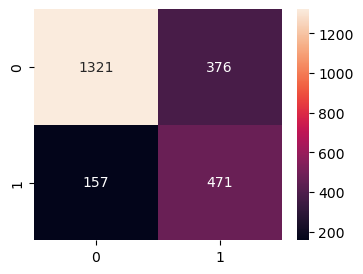

In [84]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt = "d")
plt.show()

## Model Interpretation

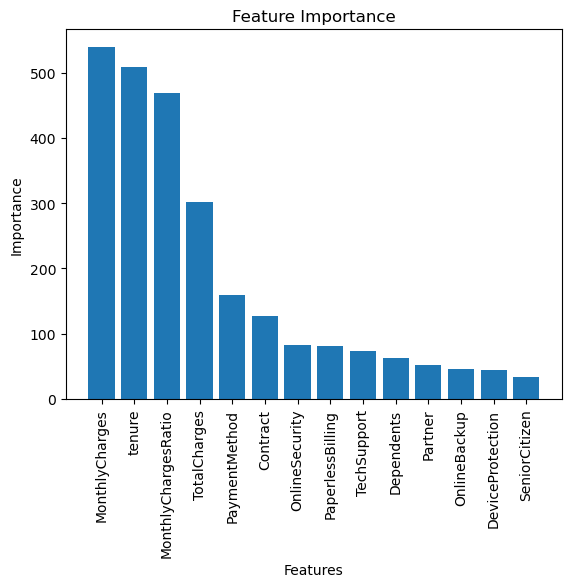

In [101]:
feature_importances = np.zeros(14)  # 14 features

for estimator in clf.estimators_:
    if hasattr(estimator, 'feature_importances_'):
        feature_importances += estimator.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), train_X.columns[indices], rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

* Monthly Charges: This feature has very high importance. As shown in the graph above, customers were more likely to churn when the monthly charges were high. Identifying patterns in customer behavior based on different charge levels allows optimizing pricing strategies or targeted promotions to reduce churn rate.

* Tenure: Naturally, fewer customers churn as the tenure increases. Thus, it is important to identify certain tenure thresholds where churn is more likely to occur, so the companies can develop respective strategies to retain customers at these points of time.

* Monthly Charges Ratio: It is a feature related to both monthly charges and tenure. It suggests that companies can examine pricing strategies and identify patterns in customer behaviors.

* Payment Method: Customers who opted for credit card transfer or bank transfer and mailed check as payment method were less likely to churn. Knowing customers' preferences in payment methods allows companies to optimize payment options to reduce churn.

* Contract: Many more customers with month-to-month contract chose to opt out compared to those with one-year or two-year contract. Companies can accordingly encourage longer-term contracts to reduce customer churn.